<a href="https://colab.research.google.com/github/IAmirKhani/Pupillary-Responses-Relationship/blob/main/NeuroVisionaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Neuromatch Academi Computational Neuroscinece project


# Importing libraries

In [ ]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Loading the dataset and preparing Colab notebook

In [ ]:
# Check for CUDA availability and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
	plt.style.use('seaborn-whitegrid')

<ipython-input-3-adcf1482bdd0>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

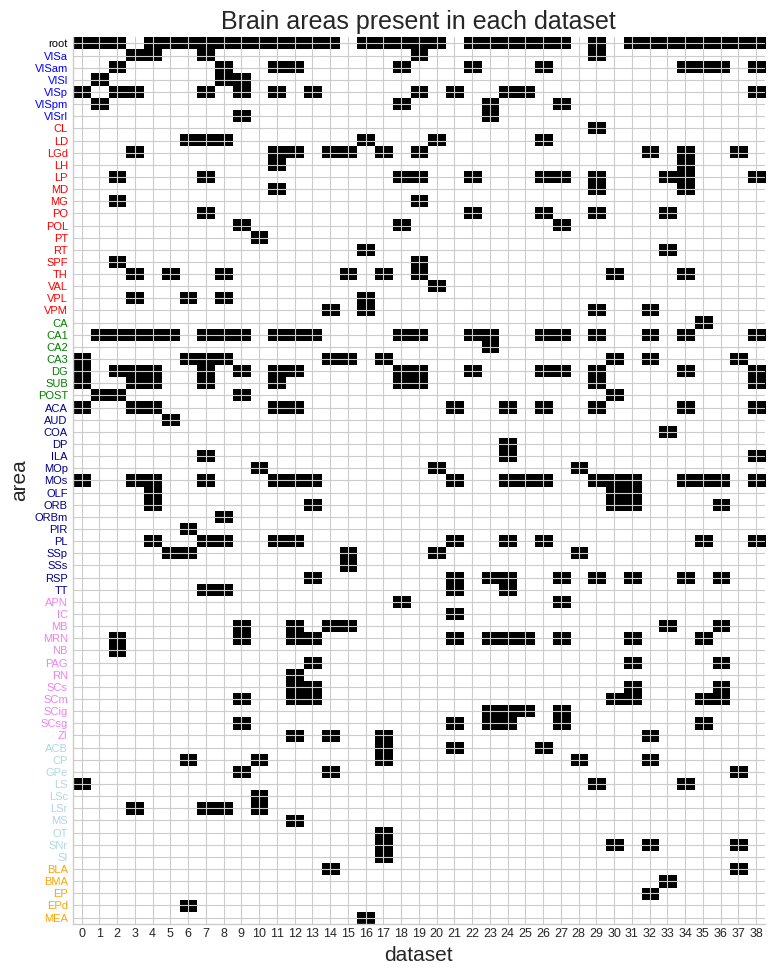

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

# Prediction of Right Contrast

## Preparing the data

In [ ]:
# Extract data for a specific session
session_number = 11
dat = alldat[session_number]

# Define the list of visual cortex areas we are interested in
visual_cortex_areas = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl', 'VISmma', 'VISli', 'VISpor']

# Extract the contrast values for the right and left trials from the data
contrast_right = dat['contrast_right']
contrast_left = dat['contrast_left']

# Extract the spike data for neurons located in the visual cortex areas
X = dat['spks'][np.isin(dat['brain_area'], visual_cortex_areas)]

# Adjust the dimensions of X for model input: (num_trials, num_neurons, time_bins)
X = X.transpose(1, 0, 2)

# Print the shape of X for reference
print('Shape of X is: ', X.shape, '(num_trial, num_neuron, num_time_bins)')

# Use contrast_right as the target variable (response) for the analysis
y = contrast_right

Shape of X is:  (340, 145, 250) (num_trial, num_neuron, num_time_bins)


In [ ]:
# The lucky mouse we're using...
dat['mouse_name']

'Lederberg'

In [ ]:
y_left = contrast_left
y_right = contrast_right

In [ ]:
classes = np.array([0.0, 0.25, 0.5, 1.0])
y_right = np.digitize(contrast_right, classes) - 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_right, test_size=0.2, random_state=42)

In [ ]:
# Reshape x_train into a two-dimensional array
n_samples, n_neurons, n_time_bins = X_train.shape
X_train_reshaped = X_train.reshape(n_samples, -1)  # Reshape to (270, 145 * 250)

# Create the RandomUnderSampler instance
under_sampler = RandomUnderSampler(random_state=42)

# Apply undersampling to x_train_reshaped
X_downsampled, y_downsampled = under_sampler.fit_resample(X_train_reshaped, y_train)

# Reshape x_train_resampled back to the original shape
X_downsampled = X_downsampled.reshape(-1, n_neurons, n_time_bins)

In [ ]:
mean_firing_rate = []
for i in range(250):
  a = X[:,:,i].mean(axis = (0,1))
  mean_firing_rate.append(a)

In [ ]:
SVMs = []
for i in range(250):
  svclassifier = SVC(kernel='rbf')
  svclassifier.fit(X_downsampled[:, :, i], y_downsampled)
  y_pred = svclassifier.predict(X_test[:,:,i])
  accuracy = accuracy_score(y_test, y_pred)
  SVMs.append(accuracy)

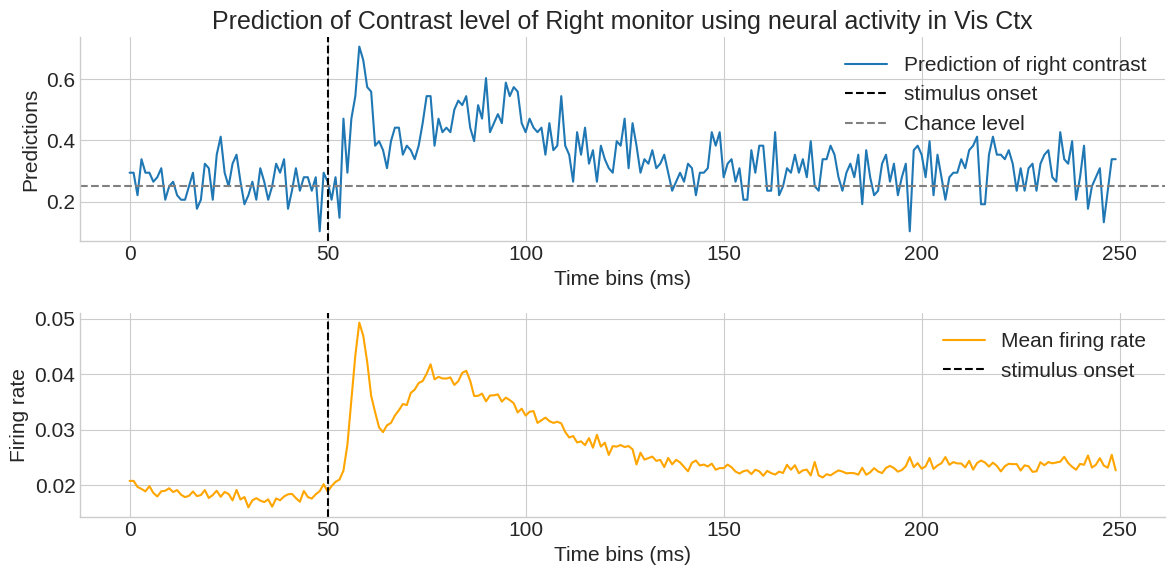

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
# Plot the first subplot (top subplot)
axes[0].plot(np.arange(250), SVMs, label='Prediction of right contrast')
axes[0].set_xlabel('Time bins (ms)')
axes[0].set_ylabel('Predictions')
axes[0].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[0].axhline(y = 0.25, color='gray', linestyle='--', label='Chance level')
axes[0].set_title('Prediction of Contrast level of Right monitor using neural activity in Vis Ctx', fontsize = 18)
axes[0].legend()

# Plot the second subplot (bottom subplot)
axes[1].plot(np.arange(250), mean_firing_rate, color = 'orange', label='Mean firing rate')
axes[1].set_xlabel('Time bins (ms)')
axes[1].set_ylabel('Firing rate')
axes[1].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define window size and step size
window_size = 10
step_size = 1

# Initialize SVMs list
window_SVMs = []

# Loop over time bins with step size
for i in range(0, X_downsampled.shape[2] - window_size + 1, step_size):
    # Create a windowed subset of your training data
    X_windowed = np.mean(X_downsampled[:, :, i:i+window_size], axis=2)

    # Train SVM classifier
    svclassifier = SVC(kernel='linear', decision_function_shape ='ovo')
    svclassifier.fit(X_windowed, y_downsampled)

    # Create a windowed subset of your test data
    X_test_windowed = np.mean(X_test[:, :, i:i+window_size], axis=2)

    # Predict on test data
    y_pred = svclassifier.predict(X_test_windowed)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append accuracy to SVMs list
    window_SVMs.append(accuracy)


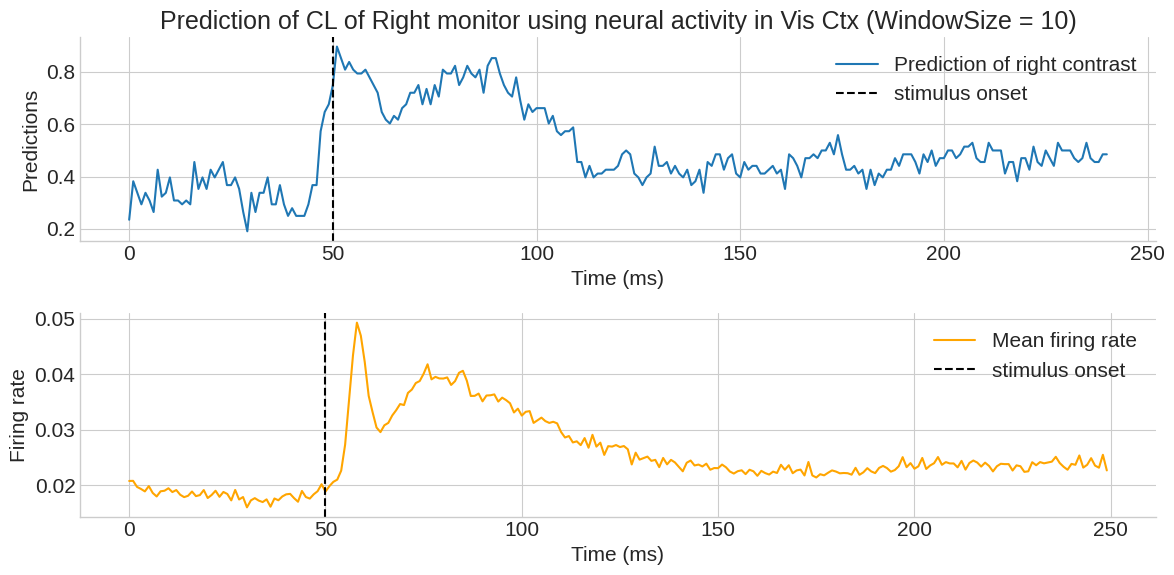

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
# Plot the first subplot (top subplot)
axes[0].plot(range(len(window_SVMs)), window_SVMs, label='Prediction of right contrast')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Predictions')
axes[0].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[0].set_title('Prediction of CL of Right monitor using neural activity in Vis Ctx (WindowSize = 10)', fontsize = 18)
axes[0].legend()

# Plot the second subplot (bottom subplot)
axes[1].plot(np.arange(250), mean_firing_rate, color = 'orange', label='Mean firing rate')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing rate')
axes[1].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[1].legend(loc = 'upper right')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

GridSearch_window_SVMs = []

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Create the SVM classifier
svclassifier = SVC()

grid_search = GridSearchCV(svclassifier, param_grid, cv=5, n_jobs=-1)

for i in range(0, 250):


    grid_search.fit(X_downsampled[:, :, i], y_downsampled)

    best_kernel = grid_search.best_params_['kernel']

    svclassifier.set_params(kernel=best_kernel)

    svclassifier.fit(X_downsampled[:, :, i], y_downsampled)

    y_pred = svclassifier.predict(X_test[:, :, i])

    accuracy = accuracy_score(y_test, y_pred)

    GridSearch_window_SVMs.append(accuracy)

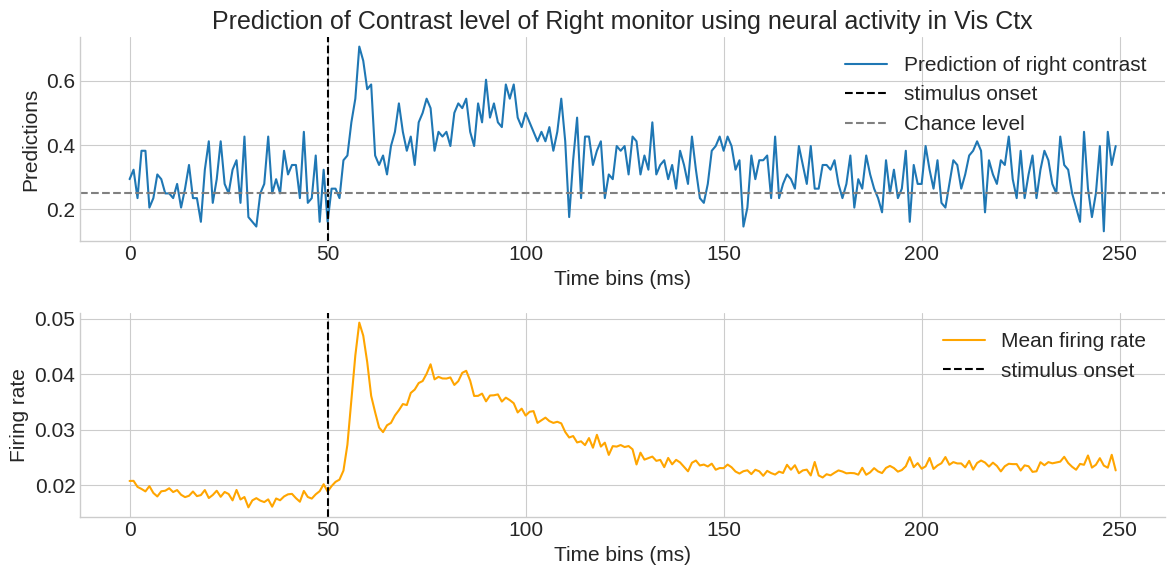

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
# Plot the first subplot (top subplot)
axes[0].plot(np.arange(250), GridSearch_window_SVMs, label='Prediction of right contrast')
axes[0].set_xlabel('Time bins (ms)')
axes[0].set_ylabel('Predictions')
axes[0].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[0].axhline(y = 0.25, color='gray', linestyle='--', label='Chance level')
axes[0].set_title('Prediction of Contrast level of Right monitor using neural activity in Vis Ctx', fontsize = 18)
axes[0].legend()

# Plot the second subplot (bottom subplot)
axes[1].plot(np.arange(250), mean_firing_rate, color = 'orange', label='Mean firing rate')
axes[1].set_xlabel('Time bins (ms)')
axes[1].set_ylabel('Firing rate')
axes[1].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to store the mean and max values and their indices
max_value = float('-inf')
max_index = 0

# Calculate the mean and find the max value and their indices
for index, value in enumerate(mean_firing_rate):
    if value > max_value:
        max_value = value
        max_index = index

print("Max Value of Mean Firing Rate:", max_value)
print("Index of Max Value:", max_index)

# Initialize variables to store the mean and max values and their indices
max_value = float('-inf')
max_index = 0

# Calculate the mean and find the max value and their indices
for index, value in enumerate(window_SVMs):
    if value > max_value:
        max_value = value
        max_index = index

print("Max Value of SVM with Window size 10:", max_value)
print("Index of Max Value:", max_index)

Max Value of Mean Firing Rate: 0.04933062880324544
Index of Max Value: 58
Max Value of SVM with Window size 10: 0.8970588235294118
Index of Max Value: 51


In [ ]:
# Initialize variables to store the mean and max values and their indices
max_value = float('-inf')
max_index = 0

# Calculate the mean and find the max value and their indices
for index, value in enumerate(SVMs):
    if value > max_value:
        max_value = value
        max_index = index

print("Max Value:", max_value)
print("Index of Max Value:", max_index)

Max Value: 0.7058823529411765
Index of Max Value: 58


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define window size and step size
window_size = 10
step_size = 1

GridSearch_window_SVMs = []

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Create the SVM classifier
svclassifier = SVC(decision_function_shape='ovo')

grid_search = GridSearchCV(svclassifier, param_grid, cv=5, n_jobs=-1)

for i in range(0, X_downsampled.shape[2] - window_size + 1, step_size):

    X_windowed = np.mean(X_downsampled[:, :, i:i+window_size], axis=2)

    grid_search.fit(X_windowed, y_downsampled)

    best_kernel = grid_search.best_params_['kernel']

    svclassifier.set_params(kernel=best_kernel)

    svclassifier.fit(X_windowed, y_downsampled)

    X_test_windowed = np.mean(X_test[:, :, i:i+window_size], axis=2)

    y_pred = svclassifier.predict(X_test_windowed)

    accuracy = accuracy_score(y_test, y_pred)

    GridSearch_window_SVMs.append(accuracy)

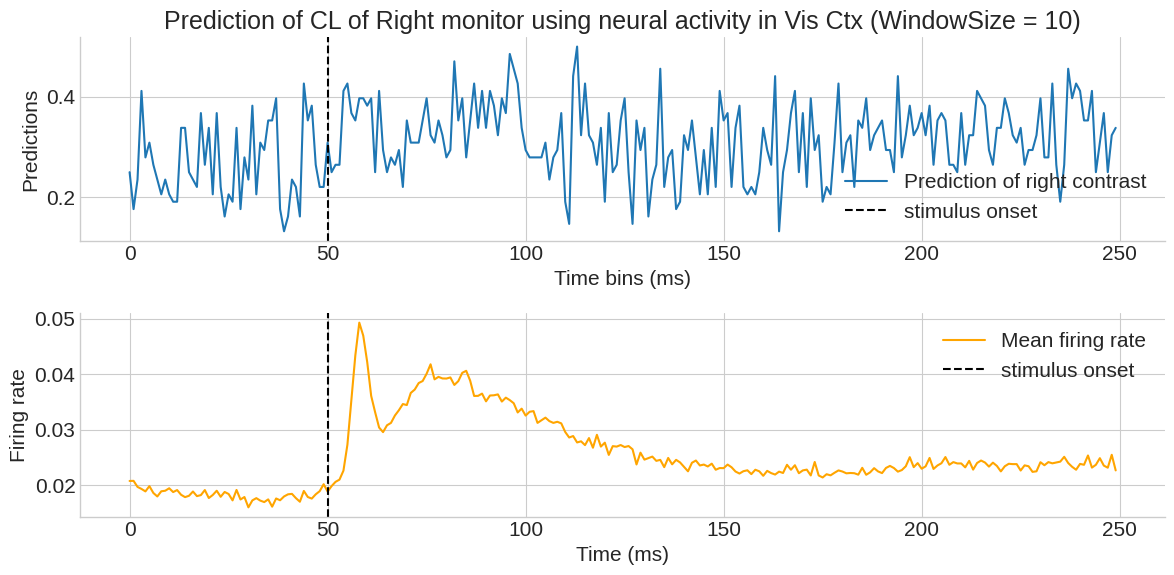

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
# Plot the first subplot (top subplot)
axes[0].plot(range(len(GridSearch_window_SVMs)), GridSearch_window_SVMs, label='Prediction of right contrast')
axes[0].set_xlabel('Time bins (ms)')
axes[0].set_ylabel('Predictions')
axes[0].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[0].set_title('Prediction of CL of Right monitor using neural activity in Vis Ctx (WindowSize = 10)', fontsize = 18)
axes[0].legend()

# Plot the second subplot (bottom subplot)
axes[1].plot(np.arange(250), mean_firing_rate, color = 'orange', label='Mean firing rate')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing rate')
axes[1].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to store the mean and max values and their indices
max_value = float('-inf')
max_index = 0

# Calculate the mean and find the max value and their indices
for index, value in enumerate(GridSearch_window_SVMs):
    if value > max_value:
        max_value = value
        max_index = index

print("Max Value:", max_value)
print("Index of Max Value:", max_index)

Max Value: 0.8970588235294118
Index of Max Value: 51


In [ ]:
from sklearn.model_selection import GridSearchCV

GridSearch_window_SVMs = []

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Create the SVM classifier
svclassifier = SVC()

grid_search = GridSearchCV(svclassifier, param_grid, cv=5, n_jobs=-1)

for i in range(0, 250):


    grid_search.fit(X_downsampled[:, :, i], y_downsampled)

    best_kernel = grid_search.best_params_['kernel']

    svclassifier.set_params(kernel=best_kernel)

    svclassifier.fit(X_downsampled[:, :, i], y_downsampled)

    y_pred = svclassifier.predict(X_test[:, :, i])

    accuracy = accuracy_score(y_test, y_pred)

    GridSearch_window_SVMs.append(accuracy)

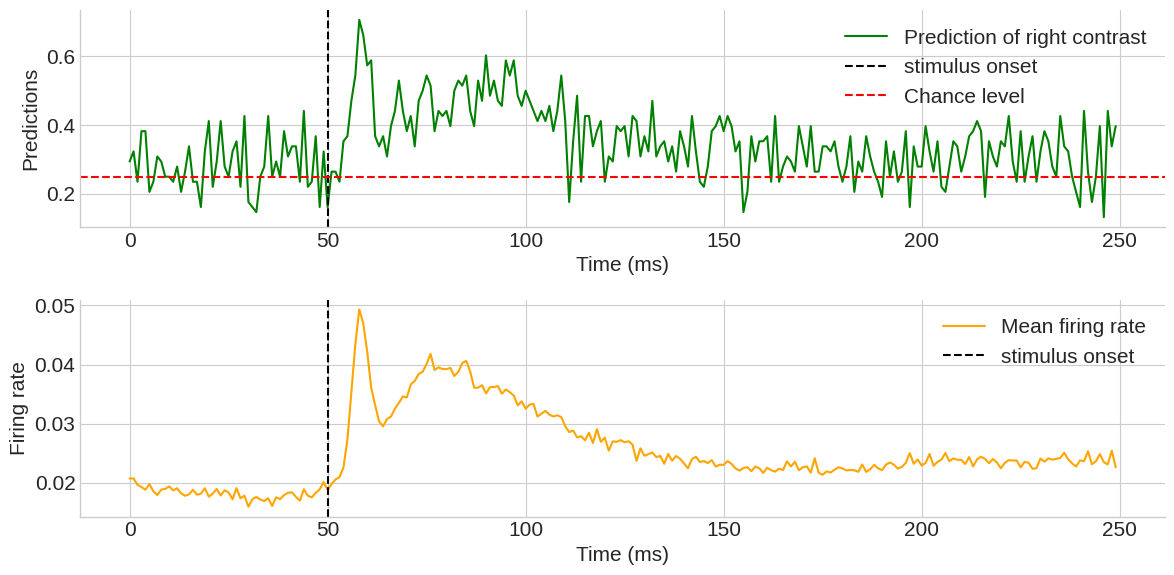

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
# Plot the first subplot (top subplot)
axes[0].plot(range(len(GridSearch_window_SVMs)), GridSearch_window_SVMs, color = 'g', label='Prediction of right contrast')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Predictions')
axes[0].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[0].axhline(y = 0.25, color='red', linestyle='--', label='Chance level')
axes[0].legend()

# Plot the second subplot (bottom subplot)
axes[1].plot(np.arange(250), mean_firing_rate, color = 'orange', label='Mean firing rate')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing rate')
axes[1].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Initialize variables to store the mean and max values and their indices
max_value = float('-inf')
max_index = 0

# Calculate the mean and find the max value and their indices
for index, value in enumerate(GridSearch_window_SVMs):
    if value > max_value:
        max_value = value
        max_index = index

print("Max Value:", max_value)
print("Index of Max Value:", max_index)

Max Value: 0.7058823529411765
Index of Max Value: 58


# Predicting Left contrast

In [ ]:
y_left = np.digitize(y_left, classes) - 1

In [ ]:
X_train_left, X_test_left, y_train_left, y_test_left = train_test_split(X, y_left, test_size=0.2, random_state=42)

In [ ]:
# Reshape x_train into a two-dimensional array
n_samples, n_neurons, n_time_bins = X_train_left.shape
X_train_reshaped = X_train_left.reshape(n_samples, -1)  # Reshape to (270, 145 * 250)

# Create the RandomUnderSampler instance
under_sampler = RandomUnderSampler(random_state=42)

# Apply undersampling to x_train_reshaped
X_downsampled, y_downsampled = under_sampler.fit_resample(X_train_reshaped, y_train_left)

# Reshape x_train_resampled back to the original shape
X_downsampled = X_downsampled.reshape(-1, n_neurons, n_time_bins)

In [ ]:
from sklearn.model_selection import GridSearchCV

GridSearch_window_SVMs = []

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Create the SVM classifier
svclassifier = SVC()

grid_search = GridSearchCV(svclassifier, param_grid, cv=5, n_jobs=-1)

for i in range(0, 250):


    grid_search.fit(X_downsampled[:, :, i], y_downsampled)

    best_kernel = grid_search.best_params_['kernel']

    svclassifier.set_params(kernel=best_kernel)

    svclassifier.fit(X_downsampled[:, :, i], y_downsampled)

    y_pred = svclassifier.predict(X_test[:, :, i])

    accuracy = accuracy_score(y_test, y_pred)

    GridSearch_window_SVMs.append(accuracy)

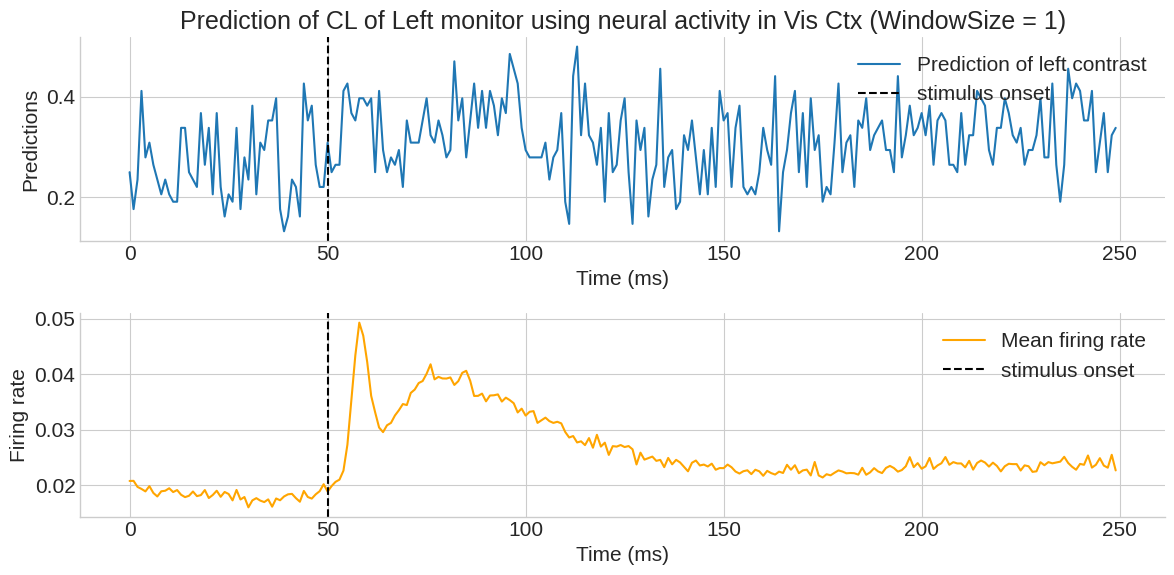

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
# Plot the first subplot (top subplot)
axes[0].plot(range(len(GridSearch_window_SVMs)), GridSearch_window_SVMs, label='Prediction of left contrast')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Predictions')
axes[0].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[0].set_title('Prediction of CL of Left monitor using neural activity in Vis Ctx (WindowSize = 1)', fontsize = 18)
axes[0].legend(loc='upper right')

# Plot the second subplot (bottom subplot)
axes[1].plot(np.arange(250), mean_firing_rate, color = 'orange', label='Mean firing rate')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing rate')
axes[1].axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
X.shape

(340, 145, 250)

In [ ]:
MUINFO_right = []
for neuron in range(X.shape[1]):
  MUINFO_right.append(mutual_info_regression(X[: ,neuron, :], contrast_right))
MUINFO_right = np.array(MUINFO_right)

In [ ]:
MUINFO_left = []
for neuron in range(X.shape[1]):
  MUINFO_left.append(mutual_info_regression(X[: ,neuron, :], contrast_left))
MUINFO_left = np.array(MUINFO_left)

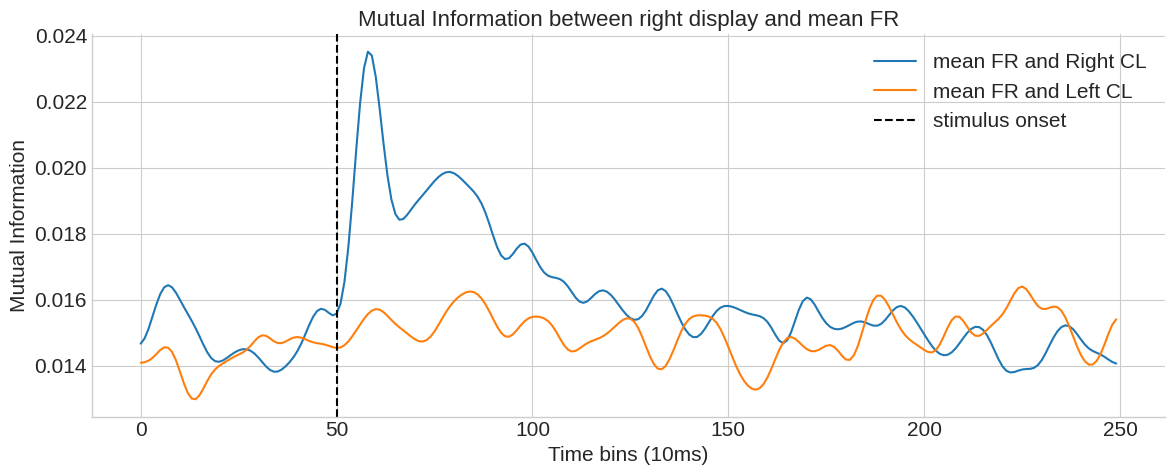

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(np.arange(250), gaussian_filter1d(np.mean(MUINFO_right, axis = 0), 3), label = 'mean FR and Right CL')
plt.plot(np.arange(250), gaussian_filter1d(np.mean(MUINFO_left, axis = 0), 3), label = 'mean FR and Left CL')
plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
plt.xlabel('Time bins (10ms)')
plt.ylabel('Mutual Information')
plt.title('Mutual Information between right display and mean FR', fontsize = 16)
plt.legend(loc='upper right')
plt.show()

# Pupil area

In [ ]:
pupil_area = dat['pupil']

In [ ]:
session_selectes = 11
dat = alldat[session_selectes]
X = dat['pupil']
print(X[:, 0, 0])
temp = []
for i in range(340):
  temp.append(X[0, i, :])

X = np.array(temp)
X = X[np.newaxis, :, :]
print('Shape of X: ', X.shape)

visual_cortex_areas = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl', 'VISmma', 'VISli', 'VISpor']
y = dat['spks'][np.isin(dat['brain_area'], visual_cortex_areas)]
print(f'Shape of y: ', y.shape)

[ 0.0790378  -0.03687325 -0.73330929]
Shape of X:  (1, 340, 250)
Shape of y:  (145, 340, 250)


In [ ]:
temp = []

for i in range(340):
  temp.append(pupil_area[0, i, :])

ppa = np.array(temp)

In [ ]:
def plot_ppa(ppa, trial):
  data = ppa[trial, :]

  plt.figure(figsize = (12, 5))
  plt.plot(np.arange(ppa.shape[1]), data, label = 'ppa')
  plt.xlabel('Time (ms)')
  plt.ylabel(f'Pupil area through the {trial}th trial')
  plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
  plt.legend()
  plt.show()

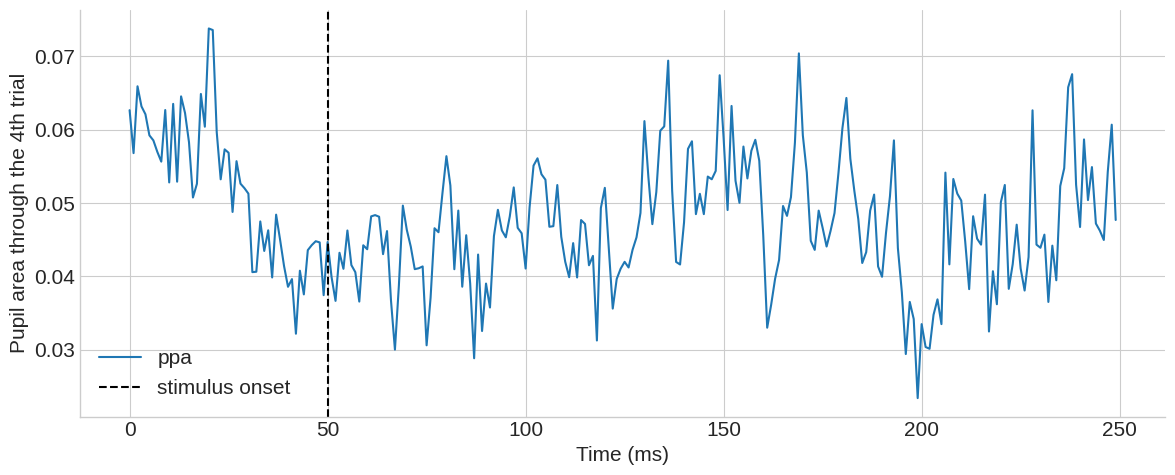

In [ ]:
plot_ppa(ppa, 4)

In [ ]:
avg_ppa = []

for i in range(250):
  data = ppa[:, i].mean(axis = 0)
  avg_ppa.append(data)

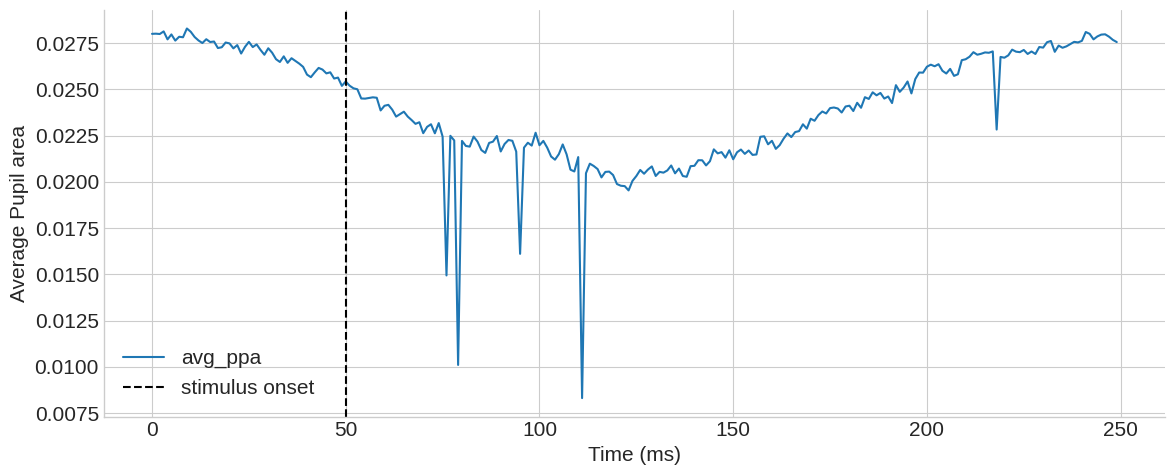

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(np.arange(250), avg_ppa, label = 'avg_ppa')
plt.xlabel('Time (ms)')
plt.ylabel(f'Average Pupil area')
plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
plt.legend()
plt.show()

##Neural activity to Pupil area

In [ ]:
session_selectes = 9
dat = alldat[session_selectes]
visual_cortex_areas = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl', 'VISmma', 'VISli', 'VISpor']
X_spks = dat['spks'][np.isin(dat['brain_area'], visual_cortex_areas)]
print(f'Shape of X: ', X_spks.shape)

y_pupil = dat['pupil']
print(y_pupil[:, 0, 0])
temp = []
for i in range(y_pupil.shape[1]):
  temp.append(y_pupil[0, i, :])

y_pupil = np.array(temp)
y_pupil = y_pupil[np.newaxis, :, :]
print('Shape of y: ', y_pupil.shape)

Shape of X:  (340, 447, 250)
[0.10163884 2.03654983 0.13232209]
Shape of y:  (1, 447, 250)


In [ ]:
temp = []

for i in range(340):
  temp.append(y_pupil[0, i, :])

ppa = np.array(temp)

In [ ]:
avg_ppa = []

for i in range(250):
  data = ppa[:, i].mean(axis = 0)
  avg_ppa.append(data)

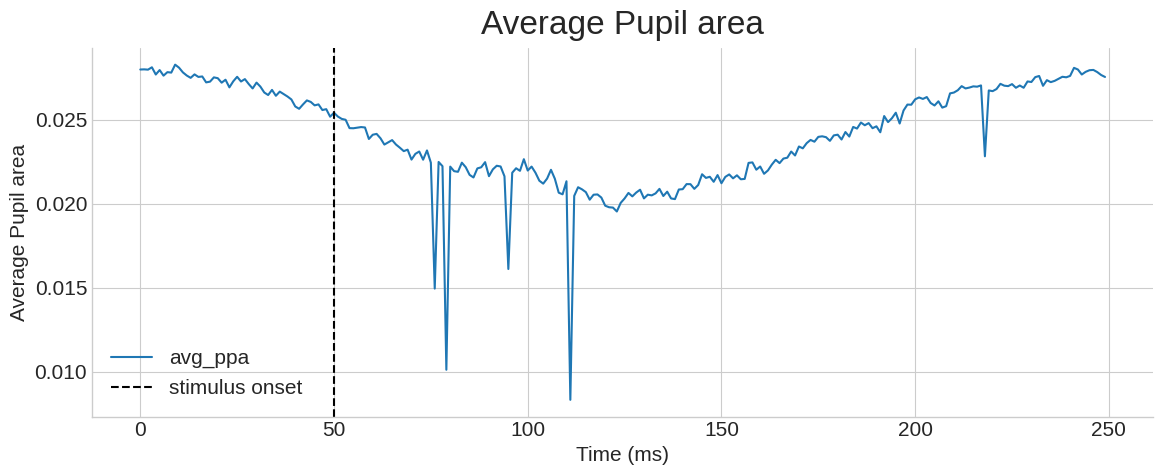

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(np.arange(250), avg_ppa, label = 'avg_ppa')
plt.xlabel('Time (ms)')
plt.ylabel(f'Average Pupil area')
plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
plt.title('Average Pupil area', fontsize = 24, pad = 10)
plt.legend()
plt.show()

In [ ]:
# Params
np.random.seed(42)

ncomp = 15
NT = 250

In [ ]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi)
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    z = F.softplus(self.fc(q), 10)
    return z, q

In [ ]:
percent_train = 0.8
num_trial = X_spks.shape[1]  # Use X.shape[0] to access the first dimension of X
idx = np.random.choice(np.arange(num_trial), num_trial, replace=False)
idx_train = idx[: int(percent_train * num_trial)]
idx_test = idx[int(percent_train * num_trial):]

x_train_pupil = X_spks[:, idx_train, :]  # Index the first dimension
y_train_pupil = y_pupil[:, idx_train, :]  # Index the first dimension

x_test_pupil = X_spks[:, idx_test, :] # Index the first dimension
y_test_pupil = y_pupil[:, idx_test, :]  # Index the first dimension

x_train_pupil = np.swapaxes(x_train_pupil, 0, 2)
y_train_pupil = np.swapaxes(y_train_pupil, 0, 2)
x_test_pupil = np.swapaxes(x_test_pupil, 0, 2)
y_test_pupil = np.swapaxes(y_test_pupil, 0, 2)

print(f'Shape of train data; input: {x_train_pupil.shape}, output: {y_train_pupil.shape}')
print(f'Shape of test data; input: {x_test_pupil.shape}, output: {y_test_pupil.shape}')

Shape of train data; input: (250, 357, 340), output: (250, 357, 1)
Shape of test data; input: (250, 90, 340), output: (250, 90, 1)


In [ ]:
input_population = torch.from_numpy(x_train_pupil).to(device).float()
output_population = torch.from_numpy(y_train_pupil).to(device).float()

In [ ]:
NN1 = input_population.shape[-1]
NN2 = output_population.shape[-1]
print(NN1, NN2)

340 1


In [ ]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2).to(device)

# special thing:  we initialize the biases of the last layer in the neural network.
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much.
net.fc.bias.data[:] = X.mean()

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0005)

In [ ]:
def mean_squared_error(lam, spk):
    return ((lam - spk) ** 2)

def mean_absolute_error(y_true, y_pred):

    mae = torch.abs(y_true - y_pred).mean()
    return mae

lambda_l2 = 0.02

niter = 1500
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(input_population)

  # our log-likelihood cost
  cost = mean_squared_error(z, output_population).sum(axis = 1).mean()

  l2_loss = 0.0
  for param in net.parameters():
    l2_loss += torch.norm(param, p=2)  # L2 norm of the weights
    # Calculate the total loss by adding the L2 regularization term
    total_loss = cost + lambda_l2 * l2_loss

  # train the network as usual
  total_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')
  if k == niter:
    print(f'iteration {k}, cost {cost.item():.4f}, Finished')

iteration 0, cost 2.4883
iteration 100, cost 0.3834
iteration 200, cost 0.3543
iteration 300, cost 0.3149
iteration 400, cost 0.2592
iteration 500, cost 0.2520
iteration 600, cost 0.2486
iteration 700, cost 0.2479
iteration 800, cost 0.2465
iteration 900, cost 0.2458
iteration 1000, cost 0.2480
iteration 1100, cost 0.2519
iteration 1200, cost 0.2559
iteration 1300, cost 0.2473
iteration 1400, cost 0.2481


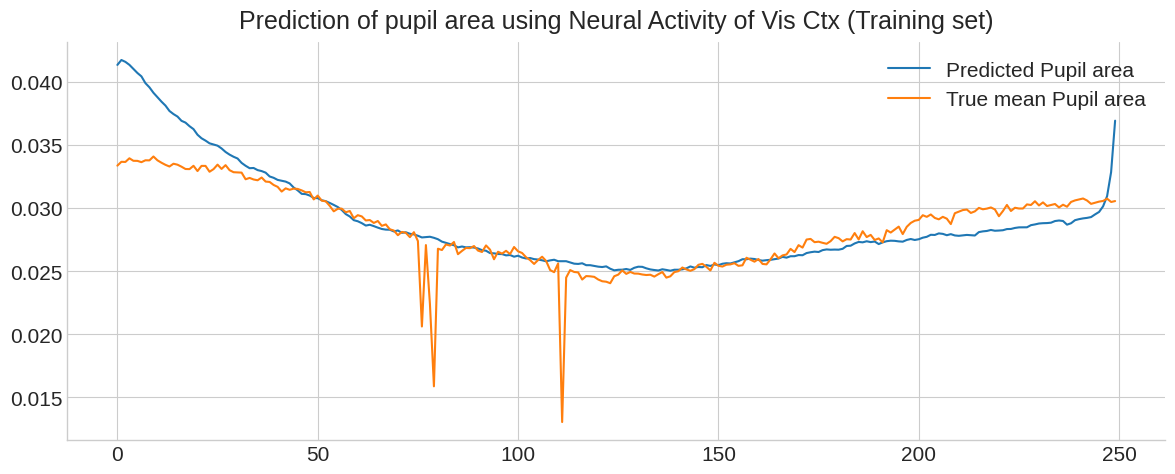

Cost on training set: 0.0006923843757249415


In [ ]:
# Training set; avg across  all trials and neurons
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train_pupil.mean(axis=(1, 2))
plt.figure(figsize=(12, 5))
plt.plot(rpred_mean)
plt.plot(y_true_mean)
plt.title('Prediction of pupil area using Neural Activity of Vis Ctx (Training set)', fontsize = 18, pad = 10)
plt.legend(['Predicted Pupil area', 'True mean Pupil area'])
plt.show()
cost_train = mean_squared_error(z, output_population).mean()
print(f'Cost on training set: {cost_train}')

In [ ]:
input_population_test = torch.from_numpy(x_test_pupil).to(device).float()
output_population_test = torch.from_numpy(y_test_pupil).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

torch.Size([250, 90, 1]) torch.Size([250, 90, 15])


Cost on test set: 0.00038765789940953255


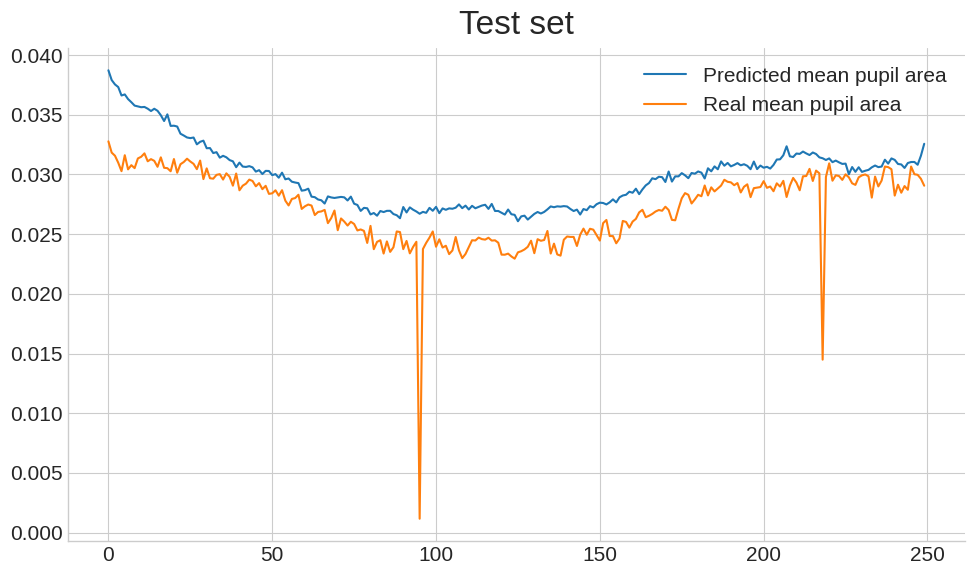

In [ ]:
# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test_pupil.mean(axis=(1, 2))
cost_test = mean_squared_error(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')
plt.figure(figsize=(10, 6))
plt.plot(rpred_mean)
plt.plot(y_true_mean)
plt.legend(['Predicted mean pupil area', 'Real mean pupil area'])
plt.title('Test set', fontsize = 24, pad = 10)
plt.show()

## Midbrain prediction

In [ ]:
session_selectes = 9
dat = alldat[session_selectes]

In [ ]:
midbrain_cortex_areas = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]
X_mid_pupil = dat['spks'][np.isin(dat['brain_area'], midbrain_cortex_areas)]
print(f'Shape of X: ', X_mid_pupil.shape)

y_mid_pupil = dat['pupil']
print(y_mid_pupil[:, 0, 0])
temp = []
for i in range(y_mid_pupil.shape[1]):
  temp.append(y_mid_pupil[0, i, :])

y_mid_pupil = np.array(temp)
y_mid_pupil = y_mid_pupil[np.newaxis, :, :]
print('Shape of y: ', y_mid_pupil.shape)


Shape of X:  (389, 447, 250)
[0.10163884 2.03654983 0.13232209]
Shape of y:  (1, 447, 250)


In [ ]:
percent_train = 0.8
num_trial = X_mid_pupil.shape[1]  # Use X.shape[0] to access the first dimension of X
idx = np.random.choice(np.arange(num_trial), num_trial, replace=False)
idx_train = idx[: int(percent_train * num_trial)]
idx_test = idx[int(percent_train * num_trial):]

x_train_mid = X_mid_pupil[:, idx_train, :]  # Index the first dimension
y_train_mid = y_mid_pupil[:, idx_train, :]  # Index the first dimension

x_test_mid = X_mid_pupil[:, idx_test, :] # Index the first dimension
y_test_mid = y_mid_pupil[:, idx_test, :]  # Index the first dimension

x_train_mid = np.swapaxes(x_train_mid, 0, 2)
y_train_mid = np.swapaxes(y_train_mid, 0, 2)
x_test_mid = np.swapaxes(x_test_mid, 0, 2)
y_test_mid = np.swapaxes(y_test_mid, 0, 2)

print(f'Shape of train data; input: {x_train_mid.shape}, output: {y_train_mid.shape}')
print(f'Shape of test data; input: {x_test_mid.shape}, output: {y_test_mid.shape}')

Shape of train data; input: (250, 357, 389), output: (250, 357, 1)
Shape of test data; input: (250, 90, 389), output: (250, 90, 1)


In [ ]:
input_population = torch.from_numpy(x_train_mid).to(device).float()
output_population = torch.from_numpy(y_train_mid).to(device).float()

In [ ]:
NN1 = input_population.shape[-1]
NN2 = output_population.shape[-1]
print(NN1, NN2)

389 1


In [ ]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2).to(device)

# special thing:  we initialize the biases of the last layer in the neural network.
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much.
net.fc.bias.data[:] = X.mean()

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.0001)

In [ ]:
def mean_squared_error(lam, spk):
    return ((lam - spk) ** 2)

def mean_absolute_error(y_true, y_pred):

    mae = torch.abs(y_true - y_pred).mean()
    return mae

lambda_l2 = 0.02

niter = 1500
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(input_population)

  # our log-likelihood cost
  cost = mean_squared_error(z, output_population).sum(axis = 1).mean()

  l2_loss = 0.0
  for param in net.parameters():
    l2_loss += torch.norm(param, p=2)  # L2 norm of the weights
    # Calculate the total loss by adding the L2 regularization term
    total_loss = cost + lambda_l2 * l2_loss

  # train the network as usual
  total_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')
  if k == niter:
    print(f'iteration {k}, cost {cost.item():.4f}, Finished')

iteration 0, cost 1.7064
iteration 100, cost 0.3358
iteration 200, cost 0.2981
iteration 300, cost 0.2624
iteration 400, cost 0.2668
iteration 500, cost 0.2544
iteration 600, cost 0.2610
iteration 700, cost 0.2533
iteration 800, cost 0.2624
iteration 900, cost 0.2552
iteration 1000, cost 0.2562
iteration 1100, cost 0.2585
iteration 1200, cost 0.2593
iteration 1300, cost 0.2565
iteration 1400, cost 0.2567


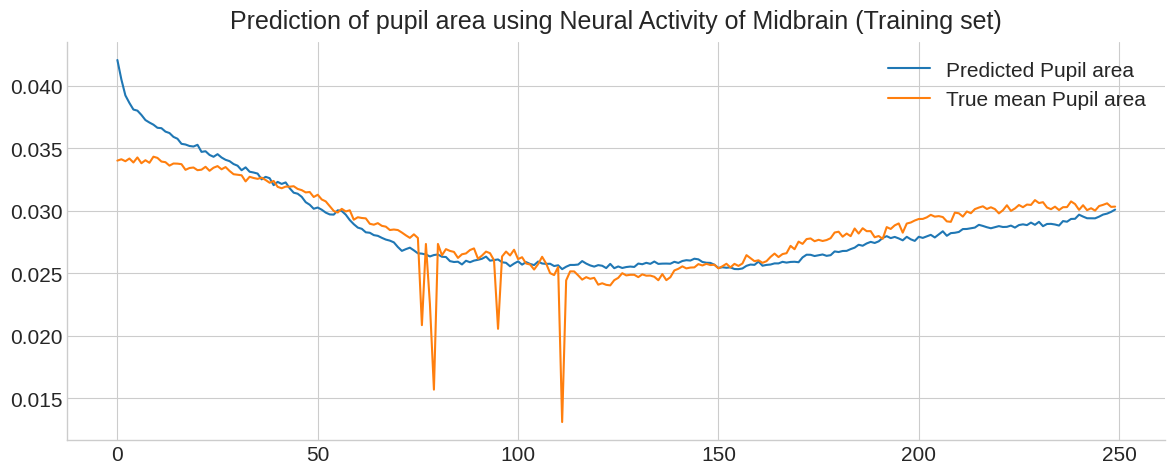

Cost on training set: 0.00989165622740984


In [ ]:
# Training set; avg across  all trials and neurons
dt = 250
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train_mid.mean(axis=(1, 2))
plt.figure(figsize=(12, 5))
plt.plot(rpred_mean)
plt.plot(y_true_mean)
plt.title('Prediction of pupil area using Neural Activity of Midbrain (Training set)', fontsize = 18, pad = 10)
plt.legend(['Predicted Pupil area', 'True mean Pupil area'])
plt.show()
cost_train = mean_absolute_error(z, output_population).mean()
print(f'Cost on training set: {cost_train}')

In [ ]:
input_population_test = torch.from_numpy(x_test_mid).to(device).float()
output_population_test = torch.from_numpy(y_test_mid).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

torch.Size([250, 90, 1]) torch.Size([250, 90, 15])


Cost on test set: 0.013036180287599564


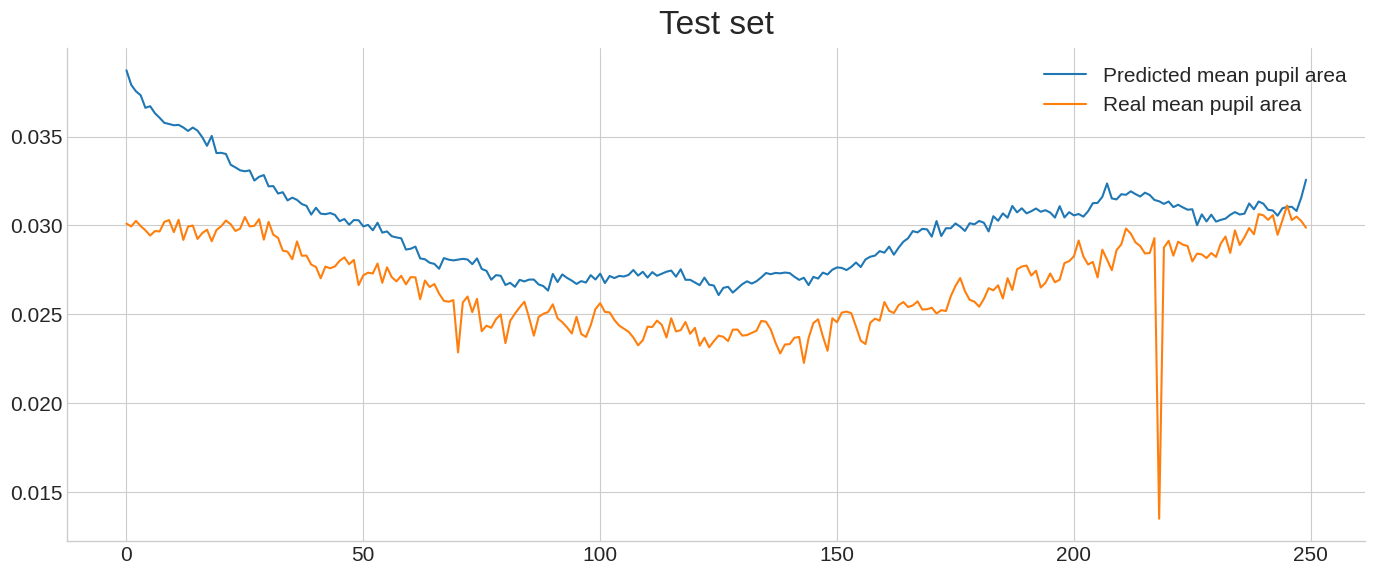

In [ ]:
# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test_mid.mean(axis=(1, 2))
cost_test = mean_absolute_error(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')
plt.figure(figsize=(14, 6))
plt.plot(rpred_mean)
plt.plot(y_true_mean)
plt.legend(['Predicted mean pupil area', 'Real mean pupil area'])
plt.title('Test set', fontsize = 24, pad = 10)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import entropy

def mutual_information(x, y):
    # Calculate the joint entropy of x and y
    joint_entropy = entropy(np.vstack((x, y)), base=2)

    # Calculate the individual entropies of x and y
    entropy_x = entropy(x, base=2)
    entropy_y = entropy(y, base=2)

    # Calculate the mutual information I(X,Y) = H(X) + H(Y) - H(X,Y)
    mutual_info_xy = entropy_x + entropy_y - joint_entropy

    return mutual_info_xy

def conditional_mutual_information(x, y, z):
    # Calculate the conditional entropy H(X|Z)
    conditional_entropy_x_z = entropy(np.vstack((x, z)), base=2) - entropy(z, base=2)

    # Calculate the conditional entropy H(Y|Z)
    conditional_entropy_y_z = entropy(np.vstack((y, z)), base=2) - entropy(z, base=2)

    # Calculate the joint entropy H(X, Y, Z)
    joint_entropy_xyz = entropy(np.vstack((x, y, z)), base=2)

    # Calculate the conditional mutual information I(X;Y|Z) = H(X|Z) + H(Y|Z) - H(X,Y|Z)
    conditional_mutual_info = conditional_entropy_x_z + conditional_entropy_y_z - joint_entropy_xyz

    return conditional_mutual_info

In [ ]:
# Calculate I(X,Y)
mutual_info_xy = mutual_information(X_mid_pupil, X_spks)

# Calculate I(X;Y|Z)
conditional_mutual_info = conditional_mutual_information(X_mid_pupil, X_spks, y_mid_pupil)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
<ipython-input-135-a574367e556e>:28: RuntimeWarning: invalid value encountered in subtract
  conditional_mutual_info = conditional_entropy_x_z + conditional_entropy_y_z - joint_entropy_xyz


In [ ]:
conditional_mutual_info.shape

(447, 250)

In [ ]:
conditional_mutual_info = conditional_mutual_info.transpose(1, 0)

In [ ]:
# for trial in range(conditional_mutual_info.shape[1]):
#   plt.figure()
#   plt.plot(np.arange(250), gaussian_filter1d(conditional_mutual_info[:, trial], 3), label = f'{trial}th trial')
#   plt.xlabel('Time (ms)')
#   plt.ylabel(f'Conidtional Mutual Information')
#   plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
#   plt.legend()
#   plt.show()

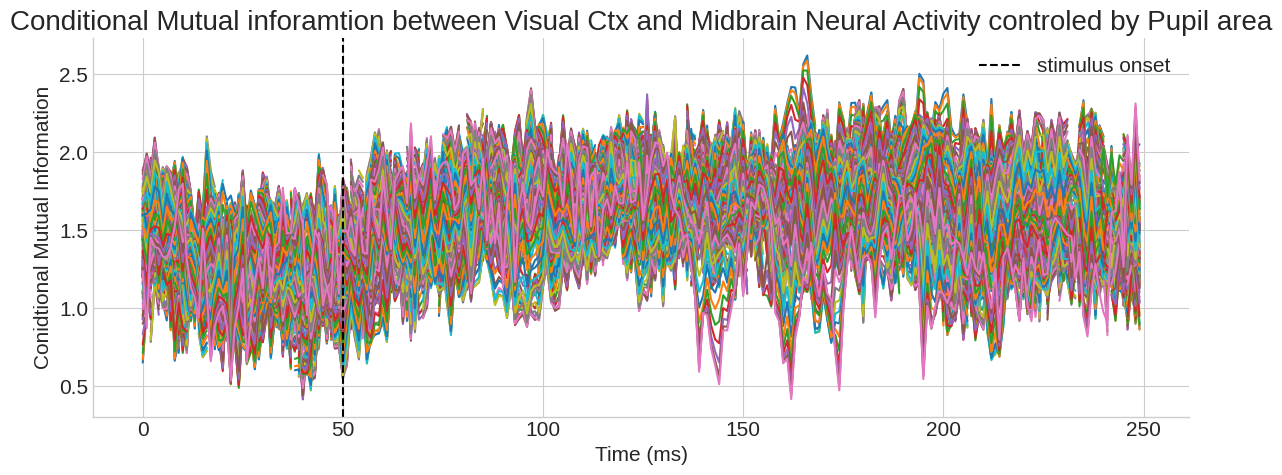

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(np.arange(250), gaussian_filter1d(conditional_mutual_info, 4))
plt.xlabel('Time (ms)')
plt.ylabel(f'Conidtional Mutual Information')
plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
plt.title('Conditional Mutual inforamtion between Visual Ctx and Midbrain Neural Activity controled by Pupil area', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
mutual_info_xy = mutual_info_xy.transpose(1, 0)

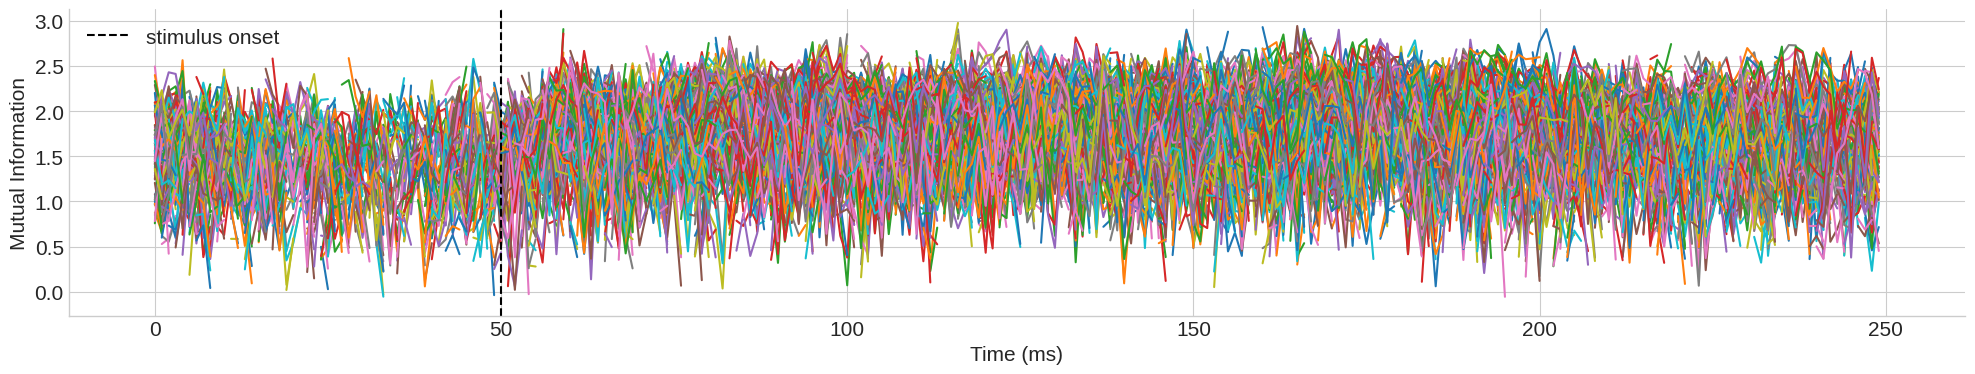

In [ ]:
plt.figure()
plt.plot(np.arange(250), gaussian_filter1d(mutual_info_xy, 1))
plt.xlabel('Time (ms)')
plt.ylabel(f'Mutual Information')
plt.axvline(x = 50, color = 'k', linestyle = '--', label = 'stimulus onset')
plt.legend()
plt.show()